<a href="https://colab.research.google.com/github/jithinraj9895/steganalysis/blob/main/Clean_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
   from torchvision.datasets import ImageFolder
   from torchvision.transforms import ToTensor
   import torchvision.transforms as transforms

In [89]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch

In [90]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import PIL as image
import pickle as pl

srm_dir = "/content/drive/MyDrive"
SRM_npy = np.load(os.path.join(srm_dir,"SRM_Kernels.npy"))

In [91]:
import torch.nn as nn
import torch.nn.functional as F

In [92]:
def activation(x):
  a = torch.ones(x.shape)
  a = torch.mul(a, -3)
  return torch.where(x > -3,x,a)


class the_tlu(nn.Module):
    def __init__(self):
        super(the_tlu, self).__init__()
        
    def forward(self, x):
        return activation(x)

In [93]:
import torch
import torch.nn as nn
from torch.optim.adamax import Adamax
from torch.optim.adadelta import Adadelta
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import Parameter

In [94]:


class SRMConv2d(nn.Module):

    def __init__(self, stride=1, padding=0):
        super(SRMConv2d, self).__init__()
        self.in_channels = 1
        self.out_channels = 30
        self.kernel_size = (5, 5)
        if isinstance(stride, int):
            self.stride = (stride, stride)
        else:
            self.stride = stride
        if isinstance(padding, int):
            self.padding = (padding, padding)
        else:
            self.padding = padding
        self.dilation = (1, 1)
        self.transpose = False
        self.output_padding = (0,)
        self.groups = 1
        self.weight = Parameter(torch.Tensor(30, 1, 5, 5), requires_grad=True)
        self.bias = Parameter(torch.Tensor(30), requires_grad=True)
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.numpy()[:] = SRM_npy
        self.bias.data.zero_()

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)


class BlockA(nn.Module):

    def __init__(self, in_planes, out_planes, norm_layer=None,activation = nn.ReLU(inplace=True)):
        super(BlockA, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = conv3x3(in_planes, out_planes)
        self.bn1 = norm_layer(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2 = norm_layer(out_planes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [95]:

def accuracy(outputs, labels):
    _, argmax = torch.max(outputs, 1)
    return (labels == argmax.squeeze()).float().mean()


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)



In [96]:
class BlockB(nn.Module):

    def __init__(self, in_planes, out_planes, norm_layer=None):
        super(BlockB, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = conv3x3(in_planes, out_planes, stride=2)
        self.bn1 = norm_layer(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2 = norm_layer(out_planes)
        # self.pool = nn.AvgPool2d(3, stride=2, padding=1)

        self.shortcut_conv = conv1x1(in_planes, out_planes, stride=2)
        self.shortcut_bn = norm_layer(out_planes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.pool(out)

        identity = self.shortcut_conv(identity)
        identity = self.shortcut_bn(identity)

        out += identity
        out = self.relu(out)

        return out


In [97]:
class KeNet(nn.Module):

    def __init__(self, norm_layer=None, zero_init_residual=True, p=0.5):
        super(KeNet, self).__init__()

        self.zero_init_residual = zero_init_residual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.srm = SRMConv2d(1, 0)
        self.bn1 = norm_layer(30)

        self.A1 = BlockA(30, 30, norm_layer=norm_layer)
        self.A2 = BlockA(30, 30, norm_layer=norm_layer)
        self.AA = BlockA(30, 30, norm_layer=norm_layer)

        # self.B1 = BlockB(30, 30, norm_layer=norm_layer)
        # self.B2 = BlockB(30, 64, norm_layer=norm_layer)

        self.B3 = BlockB(30, 64, norm_layer=norm_layer)
        self.A3 = BlockA(64, 64, norm_layer=norm_layer)

        self.B4 = BlockB(64, 128, norm_layer=norm_layer)
        self.A4 = BlockA(128, 128, norm_layer=norm_layer)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.bnfc = nn.BatchNorm1d(128)
        self.relu = nn.ReLU(inplace=True)
        # self.fcfusion = nn.Linear(128, 128) #4
        self.fc = nn.Linear(128 * 4 + 1, 2)
        self.dropout = nn.Dropout(p=p)

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.xavier_uniform_(m.weight)
                # nn.init.constant_(m.bias, 0.2)
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.01)

        if self.zero_init_residual:
            for m in self.modules():
                if isinstance(m, (BlockA, BlockB)):
                    nn.init.constant_(m.bn2.weight, 0)

    def extract_feat(self, x):
        x = x.float()
        out = self.srm(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.A1(out)
        out = self.A2(out)
        out = self.AA(out)

        # out = self.B1(out)
        # out = self.B2(out)

        out = self.B3(out)
        out = self.A3(out)

        out = self.B4(out)
        out = self.A4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), out.size(1))

        # out = self.relu(out)
        # out = self.bnfc(out)

        return out

    def forward(self, *args):
        ############# statistics fusion start #############
        feats = torch.stack(
            [self.extract_feat(subarea) for subarea in args], dim=0
        )

        euclidean_distance = F.pairwise_distance(feats[0], feats[1], eps=1e-6,
                                                 keepdim=True)

        if feats.shape[0] == 1:
            final_feat = feats.squeeze(dim=0)
        else:
            # feats_sum = feats.sum(dim=0)
            # feats_sub = feats[0] - feats[1]
            feats_mean = feats.mean(dim=0)
            feats_var = feats.var(dim=0)
            feats_min, _ = feats.min(dim=0)
            feats_max, _ = feats.max(dim=0)

            '''feats_sum = feats.sum(dim=0)
            feats_sub = abs(feats[0] - feats[1])
            feats_prod = feats.prod(dim=0)
            feats_max, _ = feats.max(dim=0)'''
            
            #final_feat = torch.cat(
            #    [feats[0], feats[1], feats[0], feats[1]], dim=-1
            #    #[euclidean_distance, feats_sum, feats_sub, feats_prod, feats_max], dim=-1
            #)

            final_feat = torch.cat(
                [euclidean_distance, feats_mean, feats_var, feats_min, feats_max], dim=-1
                #[euclidean_distance, feats_sum, feats_sub, feats_prod, feats_max], dim=-1
            )

        out = self.dropout(final_feat)
        # out = self.fcfusion(out)
        # out = self.relu(out)
        out = self.fc(out)

        return out, feats[0], feats[1]


In [98]:
def preprocess_data(images, labels, random_crop, gpu):
    # images of shape: NxCxHxW
    if images.ndim == 5:  # 1xNxCxHxW
        images = images.squeeze(0)
        labels = labels.squeeze(0)
    h, w = images.shape[-2:]

    if random_crop:
        ch = random.randint(h * 3 // 4, h)  # h // 2      #256
        cw = random.randint(w * 3 // 4, w)  # square ch   #256

        h0 = random.randint(0, h - ch)  # 128
        w0 = random.randint(0, w - cw)  # 128
    else:
        ch, cw, h0, w0 = h, w, 0, 0
 
    cw = cw & ~1
    inputs = [
                images[..., h0:h0 + ch, w0:w0 + cw // 2],
                images[..., h0:h0 + ch, w0 + cw // 2:w0 + cw]
        ]
    if gpu:
        inputs = [x.cuda() for x in inputs]
        labels = labels.cuda()
    return inputs, labels
        
    return inputs, labels

In [99]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=1.25):  # margin=2
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        label = label.to(torch.float32)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

In [100]:
model = KeNet(norm_layer=None, zero_init_residual=True, p=0.5)

In [101]:
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = ContrastiveLoss(margin=1)

In [ ]:
# inputs , labels = preprocess_data(*data,False,gpu=True)
# output, feat_0, feat_1 = model(*inputs)

# print(output,feat_0,feat_1)
# print(output.shape)
# print(feat_0.shape)

In [102]:
optimizer = Adamax(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4)

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.3,
                                                           patience=10, verbose=True, min_lr=0,
                                                           eps=1e-08)

In [ ]:
#  VALIDATION AND TRAINING STARTS #

In [103]:
def set_random_seed(seed=None):
    """Sets random seed for reproducibility.

    Args:
        seed (int, optional): Random seed.
    """
    if seed is None:
        seed = (
                os.getpid()
                + int(datetime.now().strftime("%S%f"))
                + int.from_bytes(os.urandom(2), "big")
        )
        logger = logging.getLogger(__name__)
        logger.info('Using a generated random seed {}'.format(seed))
    random.seed(seed)
    np.random.seed(seed)
    torch.set_rng_state(torch.manual_seed(seed).get_state())


def get_random_seed():
    return np.random.randint(2 ** 31)

In [155]:
import torchvision
import itertools
import logging
import math


from torch.utils.data import BatchSampler
from torch.utils.data import DataLoader
from torch.utils.data import Sampler
from torch.utils.data import SequentialSampler






class TrainingSampler(Sampler):

    def __init__(self, size, seed=None, shuffle=True):
        self._size = size
        self._shuffle = shuffle

        if seed is None:
            seed = get_random_seed()
        self._seed = seed

    def __iter__(self):
        yield from itertools.islice(self._infinite_indices(), 0, None, 1)

    def _infinite_indices(self):
        g = torch.Generator()
        g.manual_seed(self._seed)
        while True:
            if self._shuffle:
                yield from torch.randperm(self._size, generator=g)
            else:
                yield from torch.arange(self._size)


class BalancedBatchSampler(BatchSampler):

    def __init__(self, sampler, group_ids, batch_size):
        """
        Args:
            sampler (Sampler): Base sampler.
            group_ids (list[int]): If the sampler produces indices in range [0, N),
                `group_ids` must be a list of `N` ints which contains the group id of each
                sample. The group ids must be a set of integers in [0, num_groups).
            batch_size (int): Size of mini-batch.
        """
        if not isinstance(sampler, Sampler):
            raise ValueError("sampler should be an instance of torch.utils.data.Sampler, "
                             "but got sampler={}".format(sampler))

        self._sampler = sampler
        self._group_ids = np.asarray(group_ids)
        assert self._group_ids.ndim == 1
        self._batch_size = batch_size
        groups = np.unique(self._group_ids).tolist()
        assert batch_size % len(groups) == 0

        # buffer the indices of each group until batch size is reached
        self._buffer_per_group = {k: [] for k in groups}
        self._group_size = batch_size // len(groups)

    def __iter__(self):
        for idx in self._sampler:
            group_id = self._group_ids[idx]
            self._buffer_per_group[group_id].append(idx)
            if all(len(v) >= self._group_size for k, v in self._buffer_per_group.items()):
                idxs = []
                # Collect across all groups
                for k, v in self._buffer_per_group.items():
                    idxs.extend(v[:self._group_size])
                    del v[:self._group_size]

                idxs = np.random.permutation(idxs)
                yield idxs

    def __len__(self):
        raise NotImplementedError("len() of GroupedBatchSampler is not well-defined.")


def build_train_loader(cover_dir, stego_dir, batch_size=32, num_workers=0):
    transform = transforms.Compose([
        RandomRot(),
        RandomFlip(),
        ToTensor(),
    ])
    dataset = CoverStegoDataset(cover_dir, stego_dir, transform)

   # print(dataset.images)

    size = len(dataset)

    sampler = TrainingSampler(size)


    batch_sampler = BalancedBatchSampler(sampler, dataset.labels, batch_size)
    
  # print(batch_sampler)
    epoch_length = math.ceil(size / batch_size)


    train_loader = DataLoader(
        dataset,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        worker_init_fn= worker_init_reset_seed(0)
    )
    return train_loader, epoch_length

def worker_init_reset_seed(worker_id):
    set_random_seed(np.random.randint(2 ** 31) + worker_id)

In [142]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import cv2


class CoverStegoDataset(Dataset):

    def __init__(self, cover_dir, stego_dir, transform=None):
        self._transform = transform

        self.images, self.labels = self.get_items(cover_dir, stego_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.images[idx]))
        image = np.expand_dims(image, 2)  # (H, W, C)
        assert image.ndim == 3

        sample = {
            'image': image,
            'label': self.labels[idx]
        }

        if self._transform:
            sample = self._transform(sample)
        return sample

    @staticmethod
    def get_items(cover_dir, stego_dir):
        images, labels = [], []

        cover_names = sorted(os.listdir(cover_dir))
        if stego_dir is not None:
            stego_names = sorted(os.listdir(stego_dir))
            assert cover_names == stego_names

        file_names = cover_names
        if stego_dir is None:
            dir_to_label = [(cover_dir, 0), ]
        else:
            dir_to_label = [(cover_dir, 0), (stego_dir, 1)]
        for image_dir, label in dir_to_label:
            for file_name in file_names:
                image_path = os.path.join(image_dir, file_name)
                if not os.path.isfile(image_path):
                    raise FileNotFoundError('{} not exists'.format(image_path))
                images.append(image_path)
                labels.append(label)

        return images, labels

In [127]:
import numpy as np
import torch
import random


class RandomRot(object):

    def __call__(self, sample):
        rot = random.randint(0, 3)
        return {
            'image': np.rot90(sample['image'], rot, axes=[-3, -2]).copy(),
            'label': sample['label'],
        }


class RandomFlip(object):

    def __init__(self, p=0.5):
        self._p = p

    def __call__(self, sample):
        if random.random() < self._p:
            return {
                'image': np.flip(sample['image'], axis=-2).copy(),
                'label': sample['label'],
            }
        else:
            return sample


class ToTensor(object):

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        if image.ndim == 3:  # HxWxC
            image = image.transpose(2, 0, 1)
        else:  # NxHxWxC
            image = image.transpose(0, 3, 1, 2)
        return {
            'image': torch.from_numpy(image).type(torch.FloatTensor),
            'label': torch.tensor(label).long()
        }


In [128]:
covr_dir = "/content/drive/MyDrive/boss_256/256_cropped_train/cover"
steg_dir = "/content/drive/MyDrive/boss_256/256_cropped_train/stego"

covr_img = "/content/drive/MyDrive/boss_256/256_crop_test1/cover"
steg_img = "/content/drive/MyDrive/boss_256/256_crop_test1/stego"

covr_img1 = "/content/drive/MyDrive/boss_256/256_crop_test1/cover/40000.pgm"
steg_img1 = "/content/drive/MyDrive/boss_256/256_crop_test1/stego/40000.pgm"

#http://www.lirmm.fr/~chaumont/SteganalysisWithDeepLearning.html
#link for .4bpp suniward stego images boss base 256



In [108]:
print(cv2.imread(covr_img1),"\n-----------------------------\n",cv2.imread(steg_img1))

[[[137 137 137]
  [139 139 139]
  [144 144 144]
  ...
  [117 117 117]
  [115 115 115]
  [ 99  99  99]]

 [[131 131 131]
  [138 138 138]
  [145 145 145]
  ...
  [129 129 129]
  [129 129 129]
  [113 113 113]]

 [[127 127 127]
  [135 135 135]
  [144 144 144]
  ...
  [139 139 139]
  [133 133 133]
  [115 115 115]]

 ...

 [[124 124 124]
  [125 125 125]
  [122 122 122]
  ...
  [137 137 137]
  [136 136 136]
  [131 131 131]]

 [[ 90  90  90]
  [ 89  89  89]
  [ 85  85  85]
  ...
  [134 134 134]
  [133 133 133]
  [128 128 128]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 53  53  53]
  [ 52  52  52]
  [ 52  52  52]]] 
-----------------------------
 [[[137 137 137]
  [139 139 139]
  [144 144 144]
  ...
  [116 116 116]
  [115 115 115]
  [ 99  99  99]]

 [[131 131 131]
  [138 138 138]
  [145 145 145]
  ...
  [129 129 129]
  [129 129 129]
  [113 113 113]]

 [[127 127 127]
  [135 135 135]
  [144 144 144]
  ...
  [139 139 139]
  [133 133 133]
  [115 115 115]]

 ...

 [[124 124 124]
  [1

In [ ]:
# print(sorted(os.listdir(covr_dir)),"==================\n",sorted(os.listdir(steg_dir)))

In [129]:
seed = 10
set_random_seed(None if seed < 0 else seed)

In [147]:
train_loader, epoch_length = build_train_loader(
        covr_img, steg_img, batch_size=2,
        num_workers = 0
    )

In [148]:
train_loader_iter = iter(train_loader)

In [154]:
data = next(iter(train_loader_iter))
img, label = data['image'],data['label']
im , la = preprocess_data(img, label,False,gpu = False)

out, ft1, ft2 = model(*im)
print(ft1[1] , "\n================================\n",ft2[1])

tensor([0.2445, 0.3018, 0.2922, 0.2591, 0.2951, 0.2610, 0.3002, 0.2971, 0.2704,
        0.3107, 0.2812, 0.2566, 0.2741, 0.2855, 0.2856, 0.2666, 0.2569, 0.2519,
        0.2855, 0.2545, 0.2764, 0.3003, 0.2625, 0.2467, 0.2936, 0.2743, 0.2721,
        0.2889, 0.3066, 0.2699, 0.2892, 0.2977, 0.2514, 0.2600, 0.2865, 0.2505,
        0.2767, 0.3216, 0.2742, 0.2729, 0.2816, 0.2448, 0.3019, 0.2591, 0.2489,
        0.2591, 0.2513, 0.2759, 0.3081, 0.3080, 0.2688, 0.2580, 0.2700, 0.2619,
        0.2461, 0.2800, 0.2650, 0.2589, 0.3068, 0.3208, 0.2770, 0.2467, 0.2721,
        0.2521, 0.2554, 0.2807, 0.2989, 0.2453, 0.3461, 0.2747, 0.2821, 0.3367,
        0.2703, 0.2675, 0.2697, 0.3001, 0.3005, 0.2878, 0.2681, 0.2969, 0.2545,
        0.3038, 0.3171, 0.2824, 0.2959, 0.2643, 0.2373, 0.2696, 0.2800, 0.2561,
        0.2641, 0.2617, 0.3050, 0.2738, 0.3062, 0.2760, 0.2989, 0.2991, 0.3064,
        0.3099, 0.2601, 0.2568, 0.2935, 0.2660, 0.3030, 0.2434, 0.2661, 0.2676,
        0.2757, 0.2680, 0.2969, 0.3069, 

In [151]:
print(label)
print(img.shape)
print(img[0],'\n===========\n',img[1])

tensor([1, 0])
torch.Size([2, 1, 256, 256])
tensor([[[137., 139., 144.,  ..., 116., 115.,  99.],
         [131., 138., 145.,  ..., 129., 129., 113.],
         [127., 135., 144.,  ..., 139., 133., 115.],
         ...,
         [124., 125., 122.,  ..., 137., 136., 131.],
         [ 90.,  89.,  85.,  ..., 134., 133., 128.],
         [  0.,   0.,   1.,  ...,  53.,  52.,  52.]]]) 
 tensor([[[137., 139., 144.,  ..., 117., 115.,  99.],
         [131., 138., 145.,  ..., 129., 129., 113.],
         [127., 135., 144.,  ..., 139., 133., 115.],
         ...,
         [124., 125., 122.,  ..., 137., 136., 131.],
         [ 90.,  89.,  85.,  ..., 134., 133., 128.],
         [  0.,   0.,   0.,  ...,  53.,  52.,  52.]]])


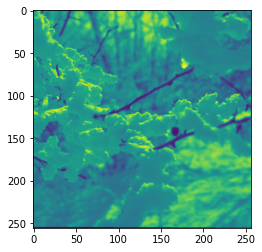

Stego
Cover


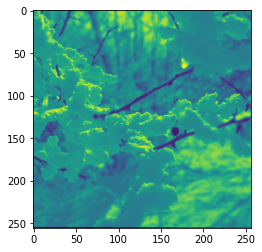

In [152]:
plt.imshow(img[0].view(256,256))
plt.show()
print("Stego\n===============\nCover")
plt.imshow(img[1].view(256,256))
plt.show()

In [135]:
out = model(img)

In [136]:
print(out.shape)

torch.Size([2, 30, 252, 252])


In [137]:
print(out[0])

tensor([[[  1.,  -2.,   5.,  ...,   0.,  -5., -10.],
         [  2.,  -1.,   0.,  ...,  12.,  17.,  18.],
         [  3.,   1.,  -1.,  ...,   4.,   8.,  14.],
         ...,
         [ -3.,  -4.,   1.,  ...,  -3.,  -3.,  -1.],
         [  0.,   5.,   8.,  ...,   2.,   2.,   2.],
         [ -3.,   2.,   0.,  ...,   6.,   6.,   6.]],

        [[  7.,  14.,  38.,  ...,   3., -14., -10.],
         [ 11.,   8.,  18.,  ...,  20.,  13.,  12.],
         [ 15.,   9.,   8.,  ...,   7.,   3.,  14.],
         ...,
         [ -3.,  -2.,  -2.,  ...,   2.,   3.,   3.],
         [  1.,   2.,   5.,  ...,   7.,   6.,   3.],
         [ -7.,  -4.,  -1.,  ...,  11.,  10.,   5.]],

        [[  9.,   9.,  18.,  ...,   8.,  -4.,  -6.],
         [ 12.,   8.,   9.,  ...,   3.,  -5.,   0.],
         [ 14.,  10.,   8.,  ...,  -1., -11.,   1.],
         ...,
         [  1.,  -3.,  -3.,  ...,   5.,   4.,   1.],
         [ -4.,  -6.,  -1.,  ...,   5.,   4.,  -1.],
         [ -9.,  -4.,   1.,  ...,   5.,   4.,  -1.]],

In [138]:
print(out[1])

tensor([[[   1.,   -2.,    5.,  ...,    1.,   -5.,  -10.],
         [   2.,    0.,    0.,  ...,   11.,   17.,   19.],
         [   3.,    0.,    0.,  ...,    4.,    8.,   13.],
         ...,
         [  -3.,   -4.,    1.,  ...,   -3.,   -3.,   -1.],
         [   0.,    5.,    8.,  ...,    2.,    2.,    2.],
         [  -3.,    2.,    0.,  ...,    6.,    6.,    6.]],

        [[   7.,   14.,   38.,  ...,    4.,  -14.,  -10.],
         [  11.,    9.,   18.,  ...,   20.,   13.,   13.],
         [  14.,    9.,    9.,  ...,    7.,    2.,   14.],
         ...,
         [  -3.,   -2.,   -2.,  ...,    2.,    3.,    3.],
         [   1.,    2.,    5.,  ...,    7.,    6.,    3.],
         [  -7.,   -4.,   -1.,  ...,   11.,   10.,    5.]],

        [[   9.,    9.,   18.,  ...,    9.,   -4.,   -6.],
         [  11.,    9.,    9.,  ...,    3.,   -6.,    1.],
         [  14.,    9.,    9.,  ...,   -1.,  -11.,    1.],
         ...,
         [   1.,   -3.,   -3.,  ...,    5.,    4.,    1.],
         [

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
if device.type == "cuda":
  model.cuda()
  criterion_1.cuda()
  criterion_2.cuda()

log_interval = 10

In [143]:
def train(epoch):
  model.train()
  running_loss, running_accuracy = 0., 0.
  for batch in range(epoch):
    data = next(iter(train_loader_iter))
    img, lab = data["image"], data["label"]
    inputs , labels = preprocess_data(img, lab, False,gpu= True)
    optimizer.zero_grad()
    output, feat_0, feat_1 = model(*inputs)
    loss = criterion_1(output, labels) + 0.1 * criterion_2(feat_0, feat_1, labels)


    the_accuracy = accuracy(output, labels).item()
  #  running_accuracy += the_accuracy
  #  running_loss += loss.item()

    loss.backward()
    optimizer.step()
    print('EPOCH :',batch,"LOSS:", loss.item(),'the_accuracy :',the_accuracy,'\n')
    model.train()


In [ ]:
def validate(epoch):
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for d in range(epoch):
      data = next(iter(train_loader_iter))
      image, lab = data["image"], data["label"]
      i, l = preprocess_data(image, lab,False,gpu = True)
      if epoch == 1:
        print(lab)
      output, feat0, feat1 = model(*i)
      for idx, j in enumerate(output):
        print(torch.argmax(j),"--",lab[idx])
        if torch.argmax(j) == lab[idx]:
          correct += 1
        total +=1
  
  print("ACCURACY :", correct/total,"total :",total, "correct :",correct )

In [ ]:
train(30)

EPOCH : 0 LOSS: 0.7630453109741211 the_accuracy : 0.4375 

EPOCH : 1 LOSS: 0.7438607215881348 the_accuracy : 0.46875 

EPOCH : 2 LOSS: 0.7605738043785095 the_accuracy : 0.53125 

EPOCH : 3 LOSS: 0.7418804168701172 the_accuracy : 0.5 

EPOCH : 4 LOSS: 0.7325146794319153 the_accuracy : 0.5 

EPOCH : 5 LOSS: 0.7607302665710449 the_accuracy : 0.46875 

EPOCH : 6 LOSS: 0.7288606762886047 the_accuracy : 0.4375 

EPOCH : 7 LOSS: 0.7279033064842224 the_accuracy : 0.53125 

EPOCH : 8 LOSS: 0.741156280040741 the_accuracy : 0.53125 

EPOCH : 9 LOSS: 0.7501487731933594 the_accuracy : 0.5 

EPOCH : 10 LOSS: 0.7096812725067139 the_accuracy : 0.46875 

EPOCH : 11 LOSS: 0.740828812122345 the_accuracy : 0.59375 

EPOCH : 12 LOSS: 0.7336735725402832 the_accuracy : 0.46875 

EPOCH : 13 LOSS: 0.7430728673934937 the_accuracy : 0.3125 

EPOCH : 14 LOSS: 0.7926653027534485 the_accuracy : 0.5625 

EPOCH : 15 LOSS: 0.7334301471710205 the_accuracy : 0.34375 

EPOCH : 16 LOSS: 0.7249271869659424 the_accuracy : 0

In [ ]:
validate(2)

tensor(1, device='cuda:0') -- tensor(1)
tensor(1, device='cuda:0') -- tensor(0)
tensor(1, device='cuda:0') -- tensor(0)
tensor(0, device='cuda:0') -- tensor(1)
tensor(0, device='cuda:0') -- tensor(1)
tensor(0, device='cuda:0') -- tensor(0)
tensor(1, device='cuda:0') -- tensor(1)
tensor(0, device='cuda:0') -- tensor(0)
tensor(0, device='cuda:0') -- tensor(0)
tensor(0, device='cuda:0') -- tensor(1)
tensor(0, device='cuda:0') -- tensor(0)
tensor(1, device='cuda:0') -- tensor(0)
tensor(1, device='cuda:0') -- tensor(0)
tensor(1, device='cuda:0') -- tensor(1)
tensor(0, device='cuda:0') -- tensor(0)
tensor(1, device='cuda:0') -- tensor(0)
tensor(1, device='cuda:0') -- tensor(0)
tensor(1, device='cuda:0') -- tensor(1)
tensor(0, device='cuda:0') -- tensor(1)
tensor(1, device='cuda:0') -- tensor(1)
tensor(1, device='cuda:0') -- tensor(0)
tensor(1, device='cuda:0') -- tensor(1)
tensor(0, device='cuda:0') -- tensor(0)
tensor(1, device='cuda:0') -- tensor(0)
tensor(1, device='cuda:0') -- tensor(1)
